<a href="https://colab.research.google.com/github/LaurenVaught/HouseRegression/blob/main/House_Price_Regression_Prediction_Ames.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Impute

In [1]:
import numpy as np
from numpy import arange
import pandas as pd
import os

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_squared_log_error


In [2]:
import matplotlib.gridspec as gridspec
from datetime import datetime
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV, LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split, StratifiedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
#from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
import xgboost as xg
#from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import matplotlib.style as style
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [3]:
#upload from raw link on github
train = pd.read_csv('https://raw.githubusercontent.com/LaurenVaught/HouseRegression/main/housetrain.csv')
test = pd.read_csv('https://raw.githubusercontent.com/LaurenVaught/HouseRegression/main/housetest.csv') 

In [4]:
#from google.colab import files
#uploaded = files.upload()

In [5]:
#import io
#train = pd.read_csv(io.BytesIO(uploaded['housetrain.csv']))
#test = pd.read_csv(io.BytesIO(uploaded['housetest.csv']))
# Dataset is now stored in a Pandas Dataframe

# EDA

In [6]:
train.shape

(1460, 81)

In [7]:
train.head()

Id  MSSubClass MSZoning  ...  SaleType  SaleCondition SalePrice
0   1          60       RL  ...        WD         Normal    208500
1   2          20       RL  ...        WD         Normal    181500
2   3          60       RL  ...        WD         Normal    223500
3   4          70       RL  ...        WD        Abnorml    140000
4   5          60       RL  ...        WD         Normal    250000

[5 rows x 81 columns]

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

##Missing values

In [9]:
#missing values
total = train.isnull().sum().sort_values(ascending = False)[train.isnull().sum().sort_values(ascending = False) != 0]
percent = (train.isnull().sum() / train.isnull().count()).sort_values(ascending = False)[(train.isnull().sum() / train.isnull().count()).sort_values(ascending = False) != 0]
missing = pd.concat([total, percent], axis = 1, keys = ['Total Missing', 'Percent Missing'])
print(missing)

              Total Missing  Percent Missing
PoolQC                 1453         0.995205
MiscFeature            1406         0.963014
Alley                  1369         0.937671
Fence                  1179         0.807534
FireplaceQu             690         0.472603
LotFrontage             259         0.177397
GarageCond               81         0.055479
GarageType               81         0.055479
GarageYrBlt              81         0.055479
GarageFinish             81         0.055479
GarageQual               81         0.055479
BsmtExposure             38         0.026027
BsmtFinType2             38         0.026027
BsmtFinType1             37         0.025342
BsmtCond                 37         0.025342
BsmtQual                 37         0.025342
MasVnrArea                8         0.005479
MasVnrType                8         0.005479
Electrical                1         0.000685


In [10]:
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

##SalePrice

In [11]:
def plotting_3_chart(train, feature):
    style.use("fivethirtyeight")
    
    fig = plt.figure(constrained_layout = True, figsize = (15, 8))#constrained_layout:auto adjust object placement.
    grid = gridspec.GridSpec(ncols = 3, nrows = 2, figure = fig)
    
    #Histogram
    ax1 = fig.add_subplot(grid[0, :2])
    ax1.set_title('Histogram')
    sns.distplot(train.loc[:, feature], norm_hist = True, ax = ax1, color = 'g')
    
    #Probability Plot
    ax2 = fig.add_subplot(grid[1, :2])
    ax2.set_title('Probability Plot')
    stats.probplot(train.loc[:, feature], plot = ax2)
    
    #Box Plot
    ax3 = fig.add_subplot(grid[:, 2])
    ax3.set_title('Box Plot')
    sns.boxplot(train.loc[:, feature], orient = 'v', ax = ax3)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


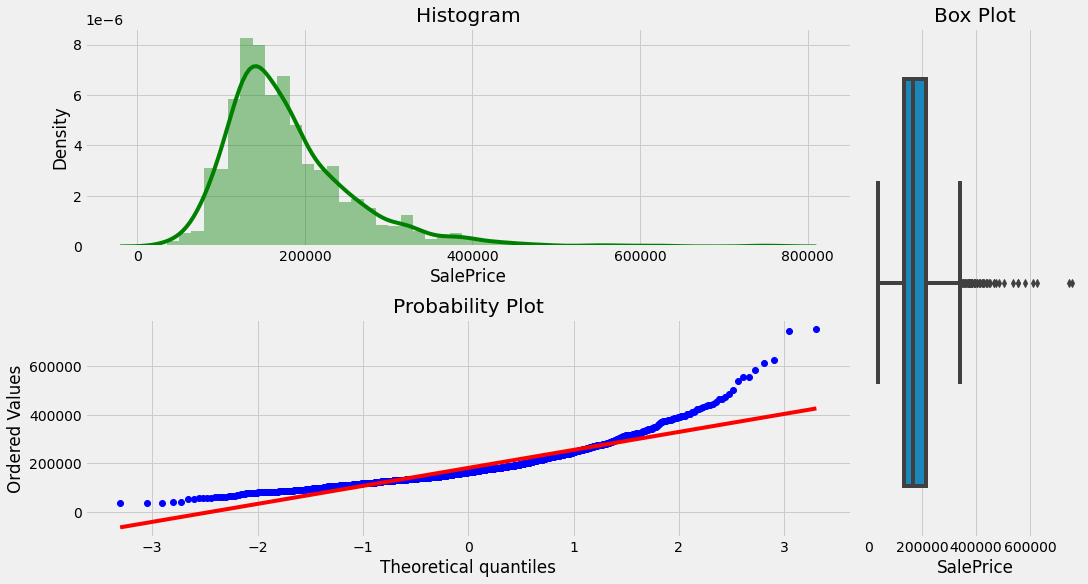

In [12]:
plotting_3_chart(train, 'SalePrice')

In [13]:
train.describe().T

count           mean  ...        75%       max
Id             1460.0     730.500000  ...    1095.25    1460.0
MSSubClass     1460.0      56.897260  ...      70.00     190.0
LotFrontage    1201.0      70.049958  ...      80.00     313.0
LotArea        1460.0   10516.828082  ...   11601.50  215245.0
OverallQual    1460.0       6.099315  ...       7.00      10.0
OverallCond    1460.0       5.575342  ...       6.00       9.0
YearBuilt      1460.0    1971.267808  ...    2000.00    2010.0
YearRemodAdd   1460.0    1984.865753  ...    2004.00    2010.0
MasVnrArea     1452.0     103.685262  ...     166.00    1600.0
BsmtFinSF1     1460.0     443.639726  ...     712.25    5644.0
BsmtFinSF2     1460.0      46.549315  ...       0.00    1474.0
BsmtUnfSF      1460.0     567.240411  ...     808.00    2336.0
TotalBsmtSF    1460.0    1057.429452  ...    1298.25    6110.0
1stFlrSF       1460.0    1162.626712  ...    1391.25    4692.0
2ndFlrSF       1460.0     346.992466  ...     728.00    2065.0
LowQualFinSF   1460.0       5.844521  ...       0.00     572.0
GrLivArea      1460.0    1515.463699  ...    1776.75    5642.0
BsmtFullBath   1460.0       0.425342  ...       1.00       3.0
BsmtHalfBath   1460.0       0.057534  ...       0.00       2.0
FullBath       1460.0       1.565068  ...       2.00       3.0
HalfBath       1460.0       0.382877  ...       1.00       2.0
BedroomAbvGr   1460.0       2.866438  ...       3.00       8.0
KitchenAbvGr   1460.0       1.046575  ...       1.00       3.0
TotRmsAbvGrd   1460.0       6.517808  ...       7.00      14.0
Fireplaces     1460.0       0.613014  ...       1.00       3.0
GarageYrBlt    1379.0    1978.506164  ...    2002.00    2010.0
GarageCars     1460.0       1.767123  ...       2.00       4.0
GarageArea     1460.0     472.980137  ...     576.00    1418.0
WoodDeckSF     1460.0      94.244521  ...     168.00     857.0
OpenPorchSF    1460.0      46.660274  ...      68.00     547.0
EnclosedPorch  1460.0      21.954110  ...       0.00     552.0
3SsnPorch      1460.0       3.409589  ...       0.00     508.0
ScreenPorch    1460.0      15.060959  ...       0.00     480.0
PoolArea       1460.0       2.758904  ...       0.00     738.0
MiscVal        1460.0      43.489041  ...       0.00   15500.0
MoSold         1460.0       6.321918  ...       8.00      12.0
YrSold         1460.0    2007.815753  ...    2009.00    2010.0
SalePrice      1460.0  180921.195890  ...  214000.00  755000.0

[38 rows x 8 columns]

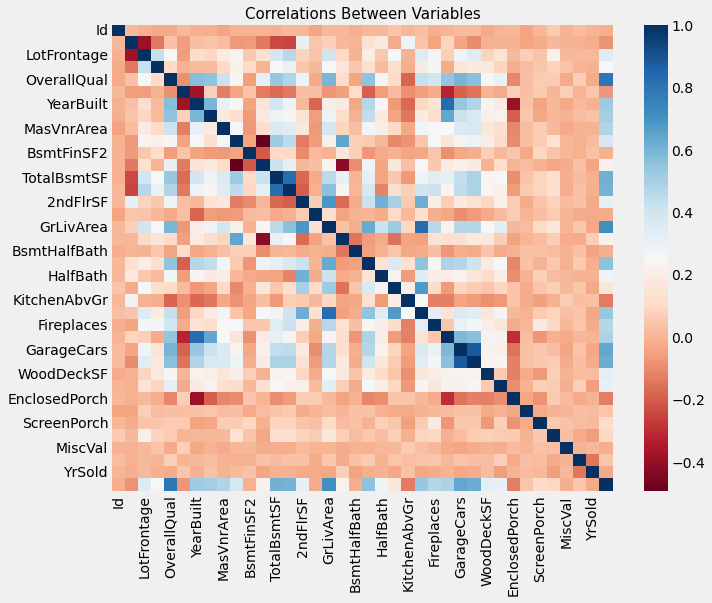

In [14]:
plt.figure(figsize=(10,8))
sns.heatmap(train.corr(), cmap="RdBu")
plt.title("Correlations Between Variables", size=15)
plt.show()

In [15]:
def select_cols_corr(df_corr, target_col, min_corr, max_corr): 
    #creating df target_corr
    target_corr = df_corr[target_col].reset_index()
    return target_corr.loc[(target_corr.iloc[:,1] < max_corr) & (target_corr.iloc[:,1] > min_corr),:]

select_cols_corr(train.corr(), 'SalePrice', min_corr=.4, max_corr=.95)

index  SalePrice
4    OverallQual   0.790982
6      YearBuilt   0.522897
7   YearRemodAdd   0.507101
8     MasVnrArea   0.477493
12   TotalBsmtSF   0.613581
13      1stFlrSF   0.605852
16     GrLivArea   0.708624
19      FullBath   0.560664
23  TotRmsAbvGrd   0.533723
24    Fireplaces   0.466929
25   GarageYrBlt   0.486362
26    GarageCars   0.640409
27    GarageArea   0.623431

In [16]:
num_col = select_cols_corr(train.corr(), 'SalePrice', min_corr=.4, max_corr=.95).iloc[:,0].tolist()

In [17]:
cat_col = train.select_dtypes(include=["object"]).columns.to_list()

In [18]:
#dropping columns except numerical, categorical, and 'SalePrice'
train.drop(train.columns.difference(cat_col + num_col + ['SalePrice']), axis=1, inplace=True)

In [19]:
#check for missing values
print("Missing Values by Column")
print("-"*30)
print(train.isna().sum())
print("-"*30)
print("TOTAL MISSING VALUES:",train.isna().sum().sum())

Missing Values by Column
------------------------------
MSZoning            0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          8
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           37
BsmtCond           37
BsmtExposure       38
BsmtFinType1       37
BsmtFinType2       38
TotalBsmtSF         0
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF            0
GrLivArea           0
FullBath            0
KitchenQual         0
TotRmsAbvGrd        0
Functional          0
Fireplaces          0
FireplaceQu       69

In [20]:
important_num_cols = list(train.corr()["SalePrice"][(train.corr()["SalePrice"]>0.50) | (train.corr()["SalePrice"]<-0.50)].index)

cat_cols = ["MSZoning", "Utilities","BldgType","Heating","KitchenQual","SaleCondition","LandSlope"]

important_cols = important_num_cols + cat_cols

df = train[important_cols]

In [21]:
#check for missing values
print("Missing Values by Column")
print("-"*30)
print(df.isna().sum())
print("-"*30)
print("TOTAL MISSING VALUES:",df.isna().sum().sum())

Missing Values by Column
------------------------------
OverallQual      0
YearBuilt        0
YearRemodAdd     0
TotalBsmtSF      0
1stFlrSF         0
GrLivArea        0
FullBath         0
TotRmsAbvGrd     0
GarageCars       0
GarageArea       0
SalePrice        0
MSZoning         0
Utilities        0
BldgType         0
Heating          0
KitchenQual      0
SaleCondition    0
LandSlope        0
dtype: int64
------------------------------
TOTAL MISSING VALUES: 0


<Figure size 720x576 with 0 Axes>

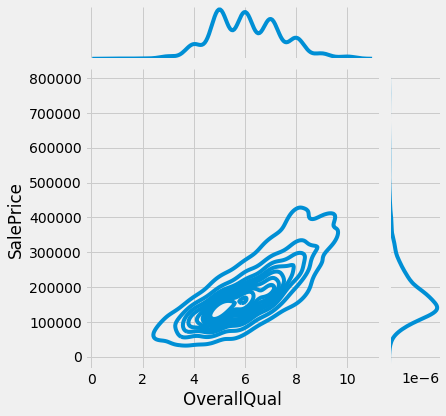

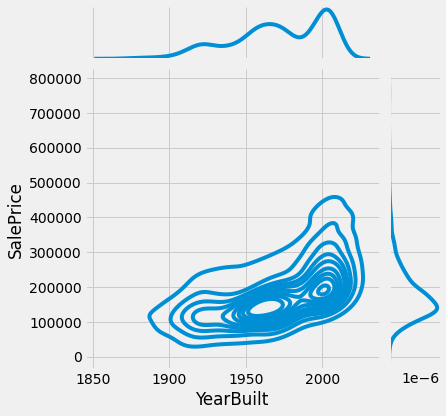

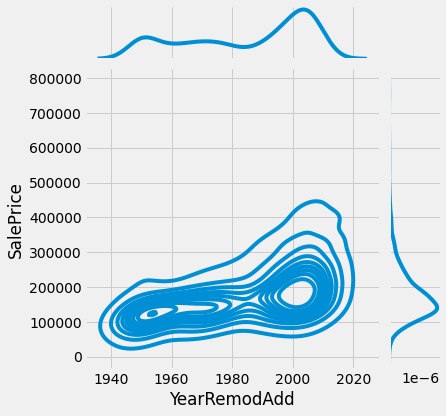

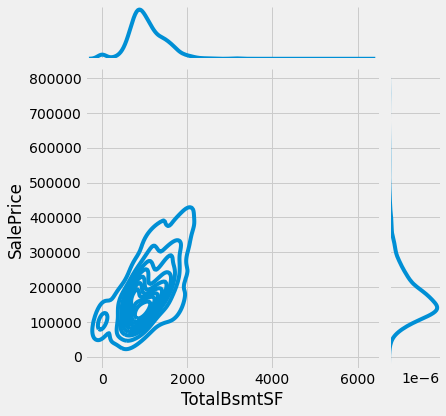

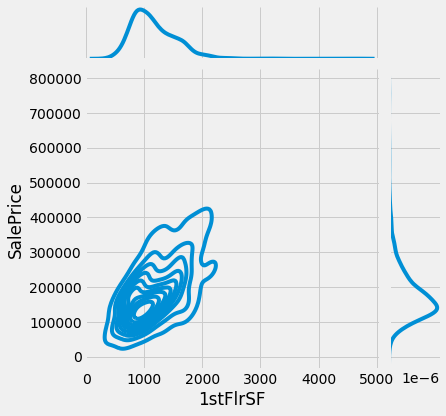

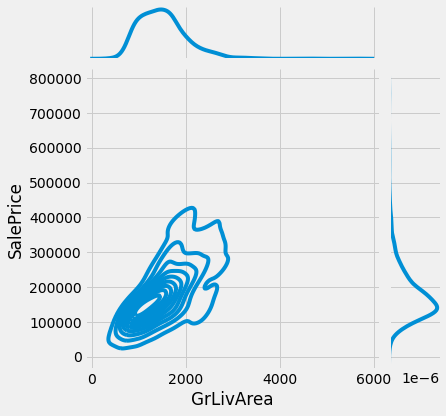

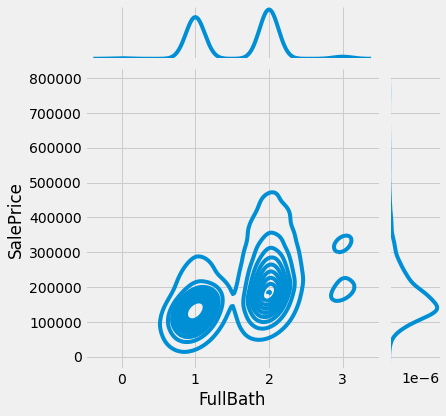

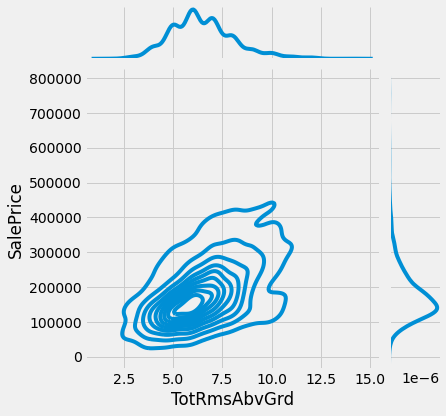

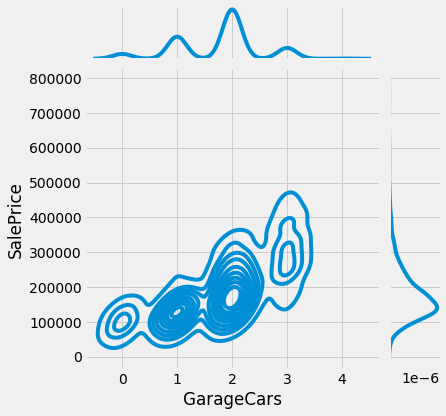

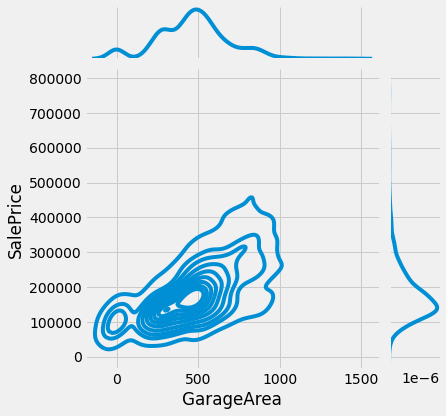

In [22]:
plt.figure(figsize=(10,8))
sns.jointplot(x=df["OverallQual"], y=df["SalePrice"], kind="kde")
sns.jointplot(x=df["YearBuilt"], y=df["SalePrice"], kind="kde")
sns.jointplot(x=df["YearRemodAdd"], y=df["SalePrice"], kind="kde")
sns.jointplot(x=df["TotalBsmtSF"], y=df["SalePrice"], kind="kde")
sns.jointplot(x=df["1stFlrSF"], y=df["SalePrice"], kind="kde")
sns.jointplot(x=df["GrLivArea"], y=df["SalePrice"], kind="kde")
sns.jointplot(x=df["FullBath"], y=df["SalePrice"], kind="kde")
sns.jointplot(x=df["TotRmsAbvGrd"], y=df["SalePrice"], kind="kde")
sns.jointplot(x=df["GarageCars"], y=df["SalePrice"], kind="kde")
sns.jointplot(x=df["GarageArea"], y=df["SalePrice"], kind="kde")
plt.show()

##Create a Feature: GrLivGarageArea

In [23]:
# Create a new feature with GrLivArea plus garage per EDA. 
train['GrLivGarageArea'] = train['GrLivArea'] + train['GarageArea']

# Check the correlation between SalePrice, the new variable, and the previous selected variables
sns.heatmap(train[['SalePrice', "FullBath" , 'GrLivArea', 'GarageArea', 'GrLivGarageArea']].corr(), cmap="RdBu", annot=True)
plt.title("Correlations Between Selected/New Variables", size=15)
plt.show()


# Modeling

##Preparing Pipeline

In [24]:
#split into train and test sets

X = train.drop(columns=['SalePrice'], axis=1)
y = train['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.75, random_state=8)

X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

In [25]:
# Categorical pipeline - filling the missing values in categorical columns using SimpleImputer and OneHotEncoder. 
cat_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('one_hot_enc', OneHotEncoder(drop='first'))
])

# Numerical pipeline - filling the missing values in numerical columns using SimpleImputer and scaling with MinMaxScaler to preserve the shape of the original distribution. 
num_pipeline = Pipeline(steps=[
    ('num_impute', SimpleImputer(strategy='mean')),
    ('scale', MinMaxScaler())
])

full_processor = ColumnTransformer(transformers=[
    ('number', num_pipeline, num_col), 
    ('category', cat_pipeline, cat_col)
])


##Linear Regression

In [26]:
lin_model_pipeline = Pipeline(steps=[
    ('processor', full_processor), 
    ('model', LinearRegression())
])

lm = lin_model_pipeline.fit(X_train, y_train)

In [27]:
lin_model_pipeline.named_steps.model.get_params()


{'copy_X': True,
 'fit_intercept': True,
 'n_jobs': None,
 'normalize': 'deprecated',
 'positive': False}


        MSE: 411059007.50333583
        RMSE: 20274.59019322797
        MAE: 13869.512712935768
        R_SQR: 0.9381634696606432
        EXV: 0.9381634696606432
        ME: 147502.4166877704
        RMSLE: 0.11258749191759747
        
744999.9148033585 34900


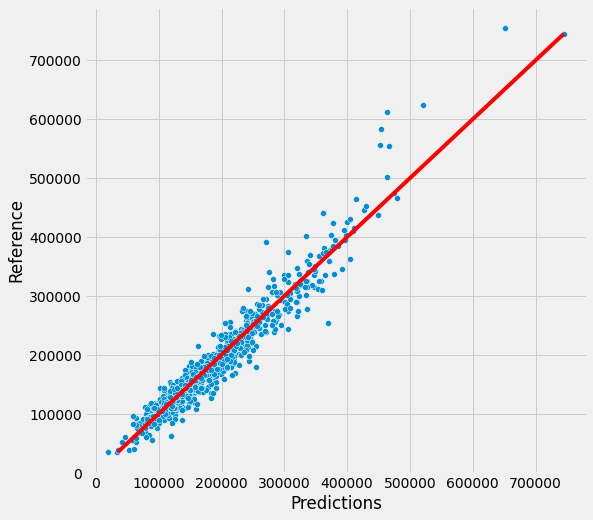

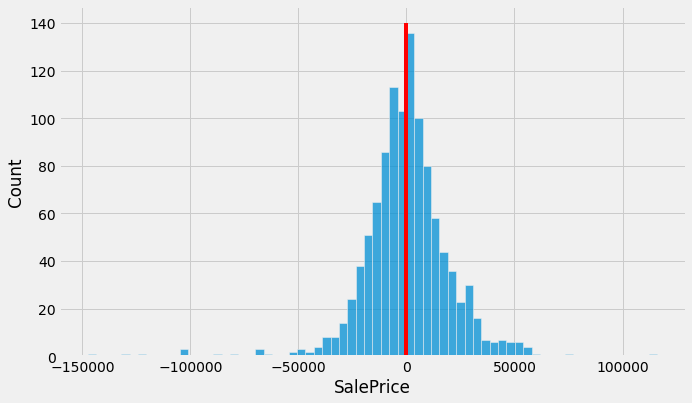

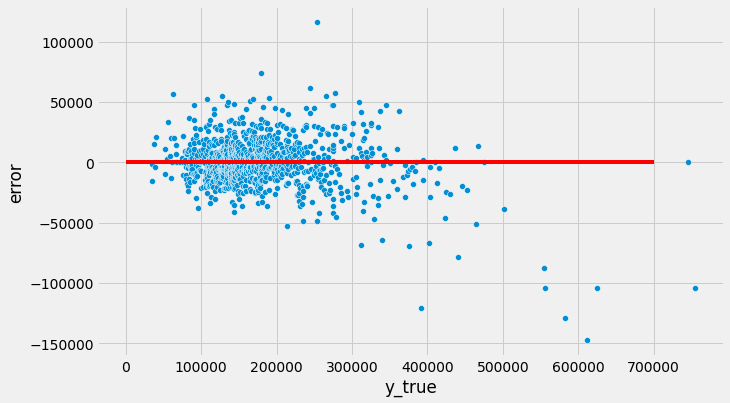

In [28]:
def plot_predictions(y_true, y_pred):
    print(
        f"""
        MSE: {mean_squared_error(y_true, y_pred)}
        RMSE: {mean_squared_error(y_true, y_pred)**0.5}
        MAE: {mean_absolute_error(y_true, y_pred)}
        R_SQR: {r2_score(y_true, y_pred)}
        EXV: {explained_variance_score(y_true, y_pred)}
        ME: {max_error(y_true, y_pred)}
        RMSLE: {mean_squared_log_error(y_true, y_pred)**0.5}
        """
    )
    max_preds = min([max(y_pred.tolist()), max(y_true.tolist())])
    min_preds = max([min(y_pred.tolist()), min(y_true.tolist())])
    print(max_preds, min_preds)
    
    # plot
    plt.figure(figsize=(8,8))
    sns.scatterplot(x=y_pred, y=y_true)
    sns.lineplot(x=[min_preds,max_preds], y=[min_preds, max_preds], color='red')
    plt.ylabel('Reference')
    plt.xlabel('Predictions')
    plt.show()
    
    errors = y_pred - y_true
    plt.subplots(figsize=(10, 6))
    sns.histplot(errors)
    plt.vlines(x = 0, ymin = 0, ymax = 140, color = 'red')
    plt.show()
    
    p_df = (
        pd.DataFrame({'y_true':y_true, 'y_pred':y_pred})
        .assign(error = lambda x: x['y_pred'] - x['y_true'])
        .sort_values(by = 'y_true')
        )
    
    plt.subplots(figsize = (10, 6))
    sns.scatterplot(data=p_df, x = 'y_true', y = 'error')
    plt.hlines(y = 0, xmin = 0, xmax = 700000, color = 'red')
    plt.show()
    
plot_predictions(y_train, lin_model_pipeline.predict(X_train))


In [29]:
lm_test = lin_model_pipeline.fit(X_test, y_test)

results = pd.DataFrame({
    'prediction': lin_model_pipeline.predict(X_test), 
    'true_value': y_test ,
    'difference': y_test - lin_model_pipeline.predict(X_test),
})

results.head()

prediction  true_value    difference
1260  184221.836250      181000  -3221.836250
274   133581.975984      124500  -9081.975984
51    126151.965160      114500 -11651.965160
117   159886.003433      155000  -4886.003433
789   203711.987715      187500 -16211.987715


        MSE: 213587735.2307506
        RMSE: 14614.641125622982
        MAE: 10174.660780386946
        R_SQR: 0.9593274266173751
        EXV: 0.9593274266173751
        ME: 78488.95178677607
        RMSLE: 0.08299838949672418
        
531319.6375966498 55000.01018255577


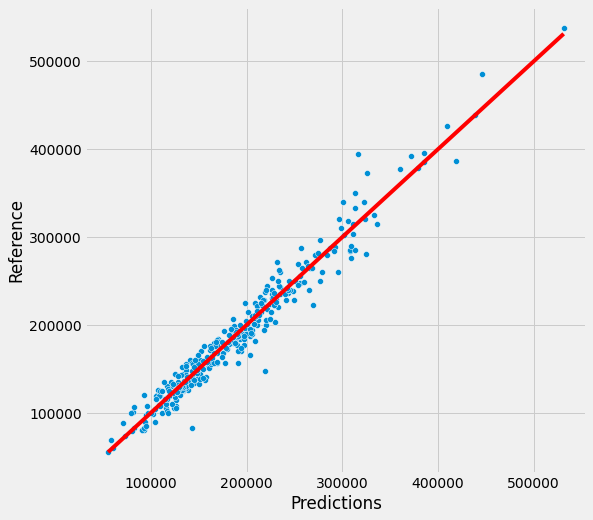

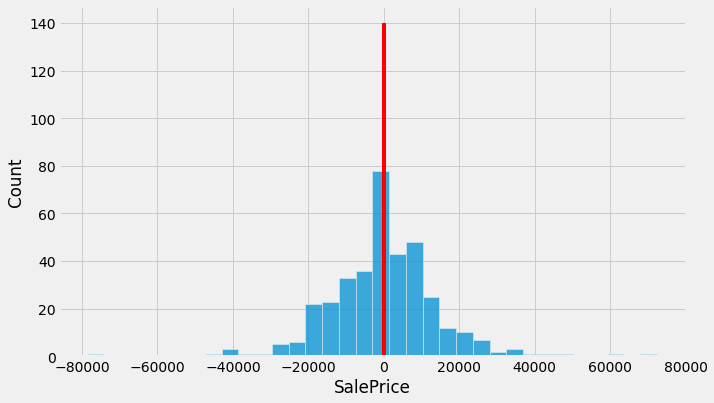

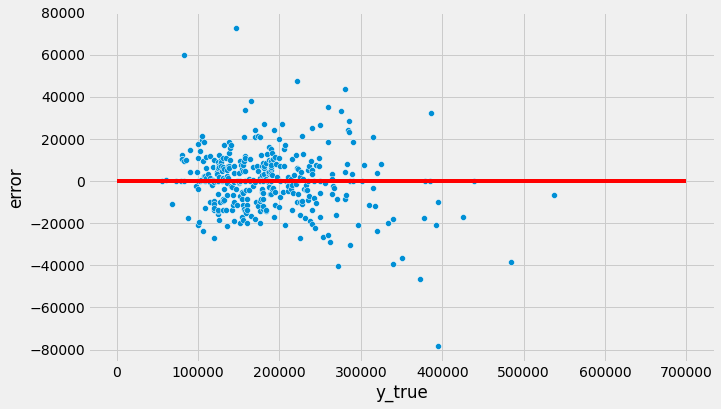

In [30]:
plot_predictions(y_test, lin_model_pipeline.predict(X_test))

In [31]:
coef_lr = pd.DataFrame(lin_model_pipeline['model'].coef_)
coef_lr

0
0    86297.184099
1    47870.074715
2    15438.413146
3    -8390.944705
4    70107.786677
..            ...
187  -4670.285142
188  28096.732109
189 -22166.651357
190   6828.313970
191  25278.327777

[192 rows x 1 columns]

In [32]:
intercept_lr = lin_model_pipeline['model'].intercept_
intercept_lr

51325.17557678334

##XGBRegressor

In [33]:
xgb_pipeline = Pipeline(steps=[
    ('processor', full_processor), 
    ('model', XGBRegressor(n_estimators=1000, learning_rate=0.01))
])

xgb = xgb_pipeline.fit(X_train, y_train)

[18:32:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



        MSE: 243638748.53630605
        RMSE: 15608.931691064128
        MAE: 11570.141413384703
        R_SQR: 0.9633488754881842
        EXV: 0.9633488979935158
        ME: 113383.5625
        RMSLE: 0.09879959996605688
        
725581.625 47379.7578125


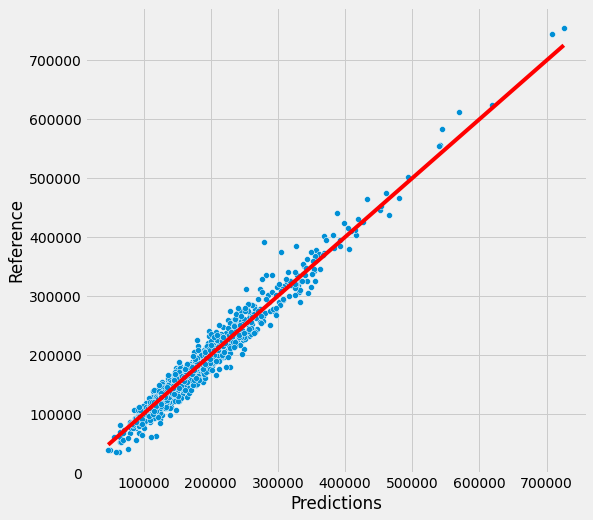

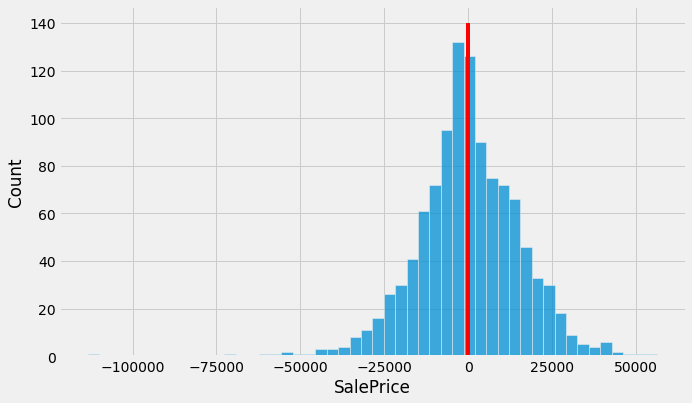

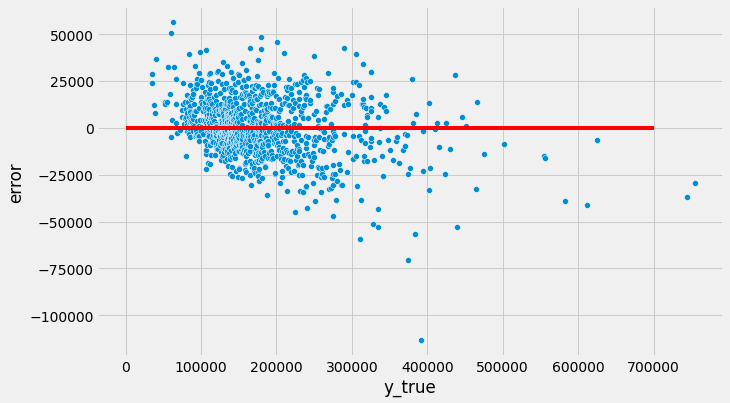

In [34]:
plot_predictions(y_train, xgb_pipeline.predict(X_train))

In [35]:
xgb_test = xgb_pipeline.fit(X_test, y_test)

results = pd.DataFrame({
    'prediction': xgb_pipeline.predict(X_test), 
    'true_value': y_test,
    'difference': y_test - xgb_pipeline.predict(X_test),
})

results.head()

[18:32:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


prediction  true_value   difference
1260  182065.984375      181000 -1065.984375
274   130385.804688      124500 -5885.804688
51    118832.429688      114500 -4332.429688
117   149212.312500      155000  5787.687500
789   192383.812500      187500 -4883.812500

##Random Forest Regression

In [36]:
rf_pipeline = Pipeline(steps=[
    ('processor', full_processor), 
    ('model', RandomForestRegressor())
])

rf = rf_pipeline.fit(X_train, y_train)


        MSE: 122977054.83638388
        RMSE: 11089.502010297121
        MAE: 6721.26250152207
        R_SQR: 0.9815002852543668
        EXV: 0.9815012280657174
        ME: 156910.09999999998
        RMSLE: 0.0630732121894761
        
688830.33 49595.26


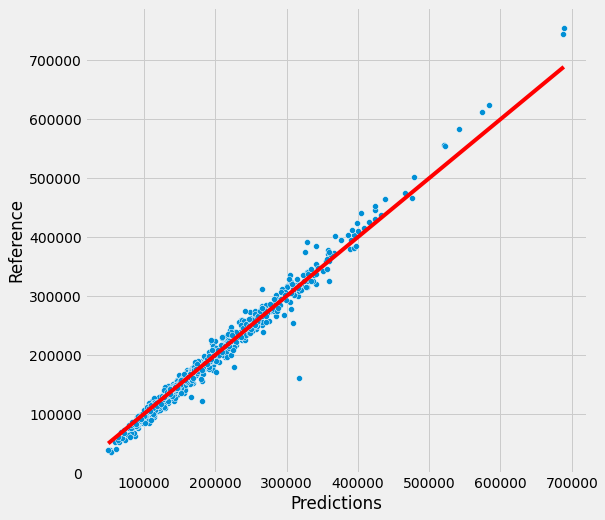

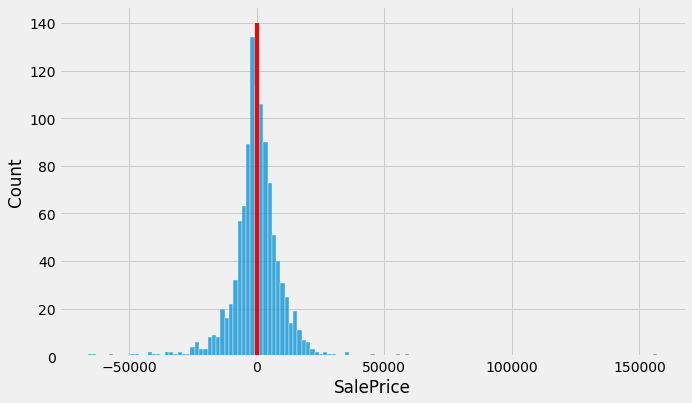

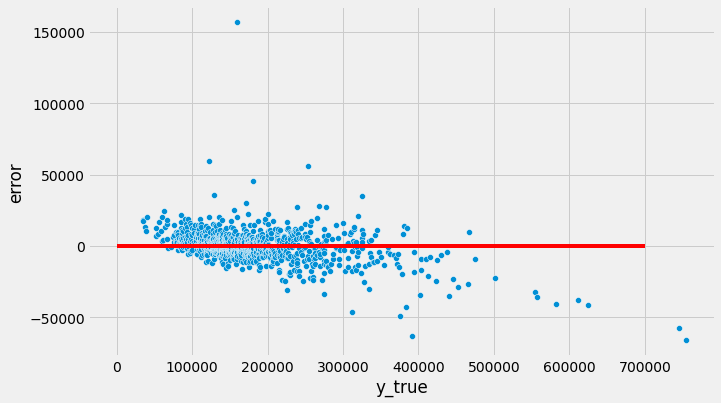

In [37]:
plot_predictions(y_train, rf_pipeline.predict(X_train))

In [38]:
rf_test = rf_pipeline.fit(X_test, y_test)

results = pd.DataFrame({
    'prediction': rf_pipeline.predict(X_test), 
    'true_value': y_test,
    'difference': y_test - rf_pipeline.predict(X_test),
})

results.head()

prediction  true_value  difference
1260   184682.00      181000    -3682.00
274    122318.00      124500     2182.00
51     115423.42      114500     -923.42
117    155404.34      155000     -404.34
789    196227.50      187500    -8727.50


        MSE: 168861463.94530684
        RMSE: 12994.670597799193
        MAE: 7789.537589041095
        R_SQR: 0.9678444538194432
        EXV: 0.9678448917220189
        ME: 100981.53999999998
        RMSLE: 0.06698387231527976
        
454828.27 67559.71


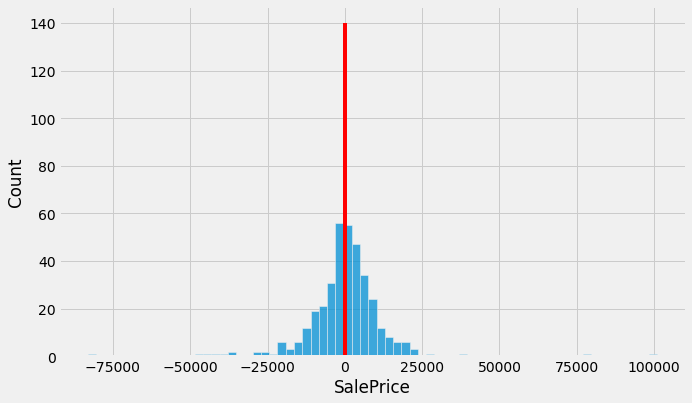

In [39]:
plot_predictions(y_test, rf_pipeline.predict(X_test))

##Ridge Regression

In [40]:
ridge_pipeline = Pipeline(steps=[
    ('processor', full_processor), 
    ('model', Ridge())
])

rd = ridge_pipeline.fit(X_train, y_train)


        MSE: 594558882.7568368
        RMSE: 24383.578136869837
        MAE: 16015.339341686707
        R_SQR: 0.9105591710167575
        EXV: 0.9105591710167577
        ME: 260981.2872974649
        RMSLE: 0.1245649989998451
        
601948.2479576308 34900


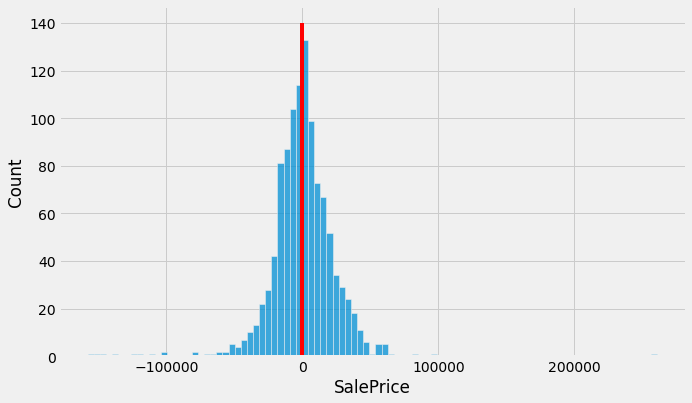

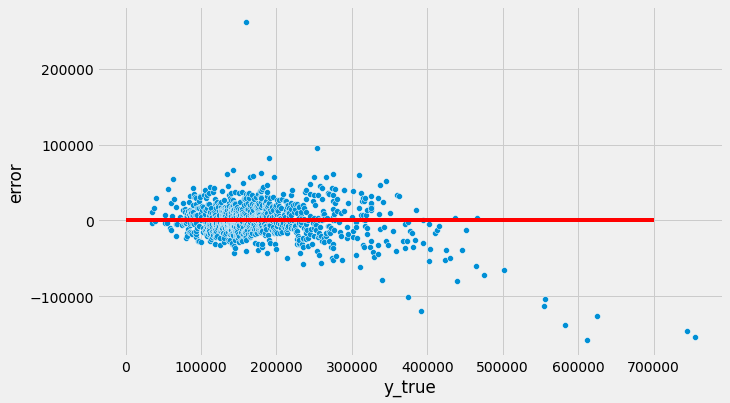

In [41]:
plot_predictions(y_train, ridge_pipeline.predict(X_train))

In [42]:
rd_test = ridge_pipeline.fit(X_test, y_test)

results = pd.DataFrame({
    'prediction': ridge_pipeline.predict(X_test), 
    'true_value': y_test,
    'difference': y_test - ridge_pipeline.predict(X_test),
})

results.head()

prediction  true_value    difference
1260  185526.412446      181000  -4526.412446
274   136283.783412      124500 -11783.783412
51    140577.559007      114500 -26077.559007
117   148801.144422      155000   6198.855578
789   210173.054337      187500 -22673.054337


        MSE: 338236587.7409624
        RMSE: 18391.20952360019
        MAE: 13010.605657499447
        R_SQR: 0.9355910936518872
        EXV: 0.9355910936518872
        ME: 93140.96524787252
        RMSLE: 0.10206633096073607
        
496294.2907984772 56535.69912340984


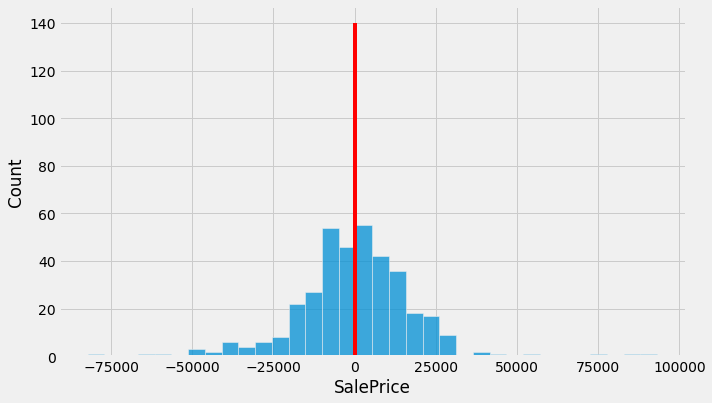

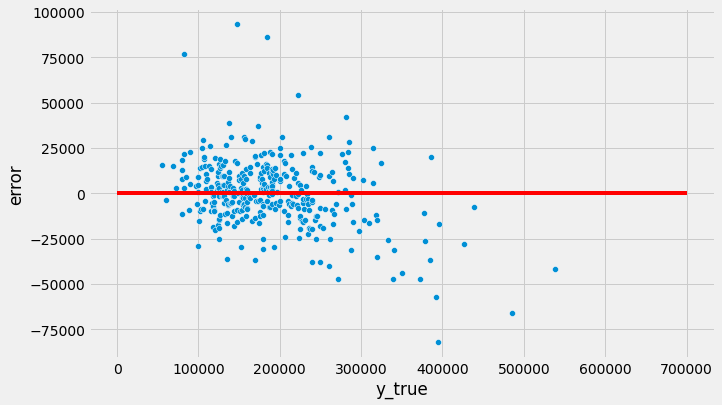

In [43]:
plot_predictions(y_test, ridge_pipeline.predict(X_test))


##Lasso Regression

In [44]:
lasso_pipeline = Pipeline(steps=[
    ('processor', full_processor), 
    ('model', Lasso())
])

ls = lasso_pipeline.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5149236768.495911, tolerance: 727902440.1045245
  positive,



        MSE: 411596536.48363596
        RMSE: 20287.84208543718
        MAE: 13899.566235904447
        R_SQR: 0.9380826079680592
        EXV: 0.9380826079680592
        ME: 147769.26514524978
        RMSLE: 0.11209790411680333
        
742809.9663038773 34900


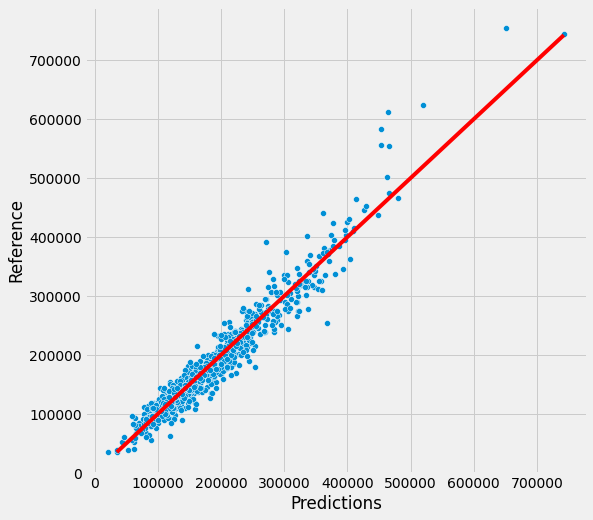

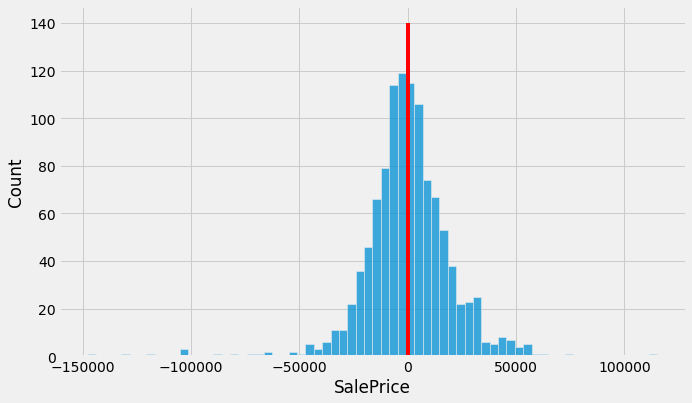

In [45]:
plot_predictions(y_train, lasso_pipeline.predict(X_train))

In [46]:
ls_test = lasso_pipeline.fit(X_test, y_test)

results = pd.DataFrame({
    'prediction': lasso_pipeline.predict(X_test), 
    'true_value': y_test,
    'difference': y_test - lasso_pipeline.predict(X_test),
})

results.head()

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11100782319.458061, tolerance: 191675905.59324658
  positive,


prediction  true_value    difference
1260  184396.354221      181000  -3396.354221
274   134065.554537      124500  -9565.554537
51    126497.694246      114500 -11997.694246
117   160392.418293      155000  -5392.418293
789   203667.700685      187500 -16167.700685


        MSE: 214027574.67024058
        RMSE: 14629.681290795113
        MAE: 10220.271635829558
        R_SQR: 0.9592436699266649
        EXV: 0.9592436699266649
        ME: 78897.47488471726
        RMSLE: 0.08270757159192547
        
531607.4698888446 55000


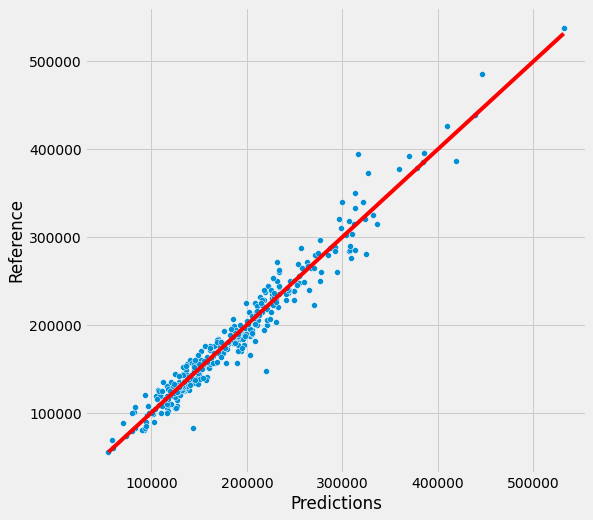

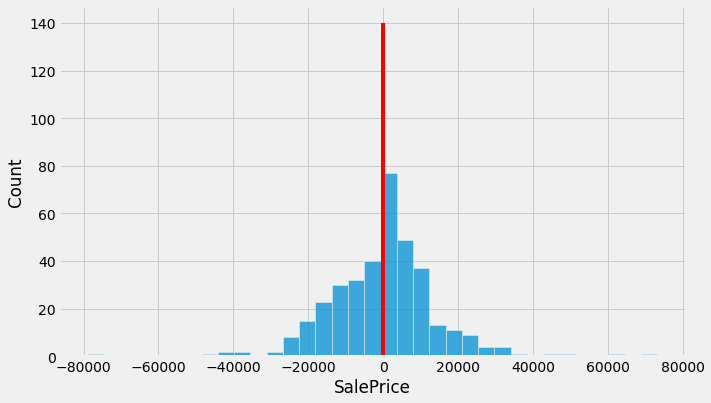

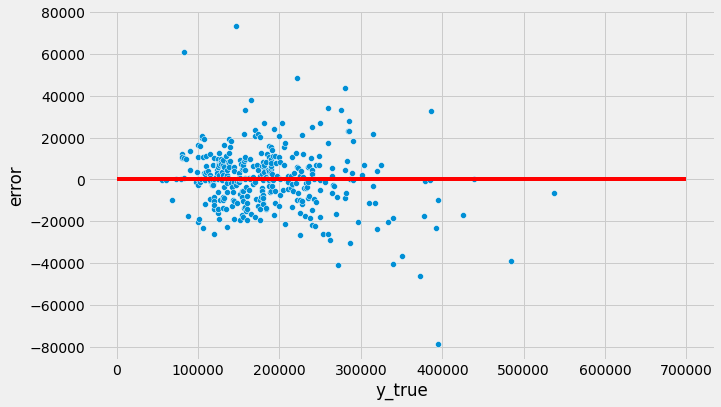

In [47]:
plot_predictions(y_test, lasso_pipeline.predict(X_test))

##ElasticNet

In [48]:
elastic_pipeline = Pipeline(steps=[
    ('processor', full_processor), 
    ('model', ElasticNet())
])

en = elastic_pipeline.fit(X_train, y_train)


        MSE: 2641832013.9678698
        RMSE: 51398.75498460901
        MAE: 32004.095021155015
        R_SQR: 0.6025832727144838
        EXV: 0.6025832727144838
        ME: 473674.99795810285
        RMSLE: 0.24212913438303255
        
307618.16338307166 101391.34507555114


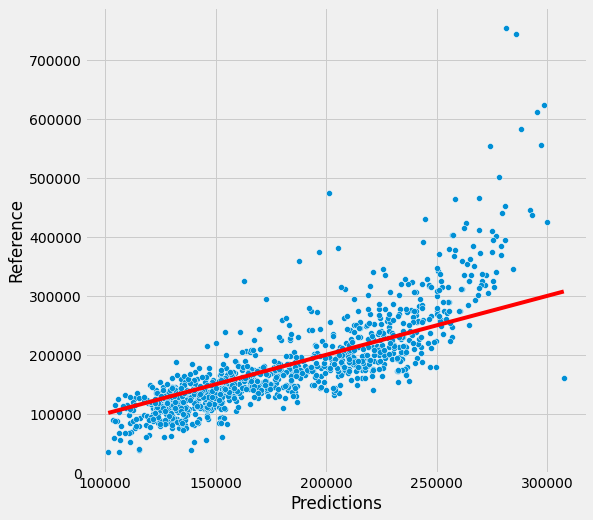

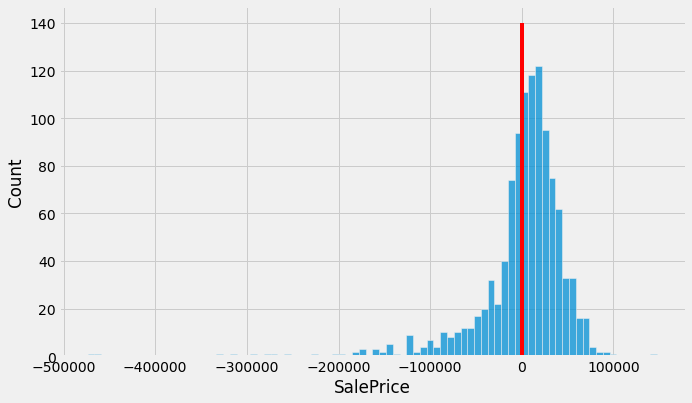

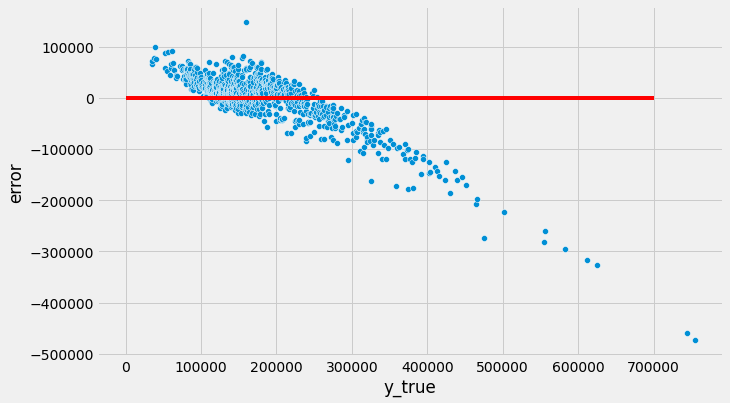

In [49]:
plot_predictions(y_train, elastic_pipeline.predict(X_train))

In [50]:
en_test = elastic_pipeline.fit(X_test, y_test)

results = pd.DataFrame({
    'prediction': elastic_pipeline.predict(X_test), 
    'true_value': y_test,
    'difference': y_test - elastic_pipeline.predict(X_test),
})

results.head()

prediction  true_value    difference
1260  190077.727439      181000  -9077.727439
274   143692.049748      124500 -19192.049748
51    131561.339087      114500 -17061.339087
117   175746.246937      155000 -20746.246937
789   200598.069992      187500 -13098.069992

###ElasticNet Tuned

In [51]:
#Tuning ElasticNet
en_alphas = [0.0001, 0.001, 0.01, 0.1, 0.0, 1.0, 10.0, 100.0]
en_ratios = arange(0, 1, 0.01)
entuned_model = ElasticNetCV(alphas=en_alphas, l1_ratio=en_ratios, cv=5, max_iter=10)

elastictuned_pipeline = Pipeline(steps=[
    ('processor', full_processor), 
    ('model', ElasticNetCV(alphas=en_alphas, l1_ratio=en_ratios, cv=5, max_iter=10))
])

entuned = elastictuned_pipeline.fit(X_train, y_train)

#optimal_alpha = entuned_model.alpha_
#optimal_ratio = entuned_model.l1_ratio_

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 908556621651.4364, tolerance: 579726599.1405338
  positive,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 447637630336.7105, tolerance: 579726599.1405338
  positive,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 292639186256.3385, tolerance: 579726599.1405338
  positive,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning: Objective did not converge. You might want to increase 


        MSE: 793243359.6320785
        RMSE: 28164.576326159757
        MAE: 18359.666916592418
        R_SQR: 0.8806706186240566
        EXV: 0.8806706186240566
        ME: 290826.4153105404
        RMSLE: 0.14247020925295678
        
531071.7602576324 44364.36229298044


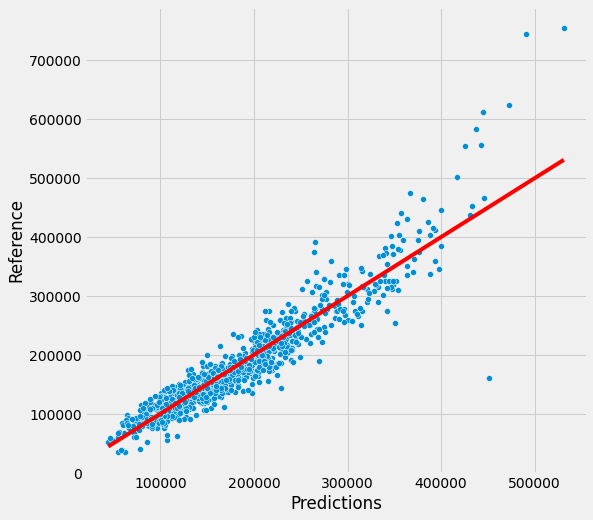

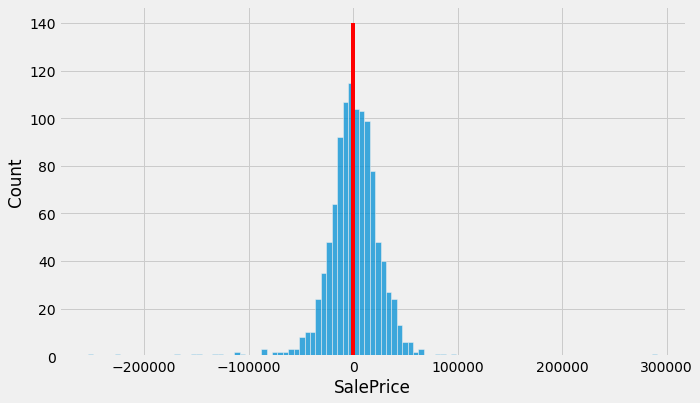

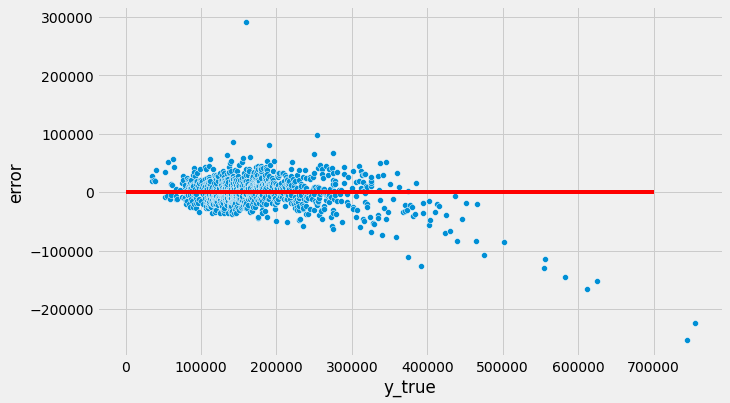

In [52]:
plot_predictions(y_train, elastictuned_pipeline.predict(X_train))

In [53]:
entuned_test = elastictuned_pipeline.fit(X_test, y_test)

results = pd.DataFrame({
    'prediction': elastictuned_pipeline.predict(X_test), 
    'true_value': y_test,
    'difference': y_test - elastictuned_pipeline.predict(X_test),
})

results.head()

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28783029045.818596, tolerance: 157744399.20742294
  positive,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 171026957862.10516, tolerance: 156835563.99197638
  positive,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 221442745648.20728, tolerance: 156835563.99197638
  positive,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning: Objective did not converge. You might want to inc

prediction  true_value    difference
1260  179005.970790      181000   1994.029210
274   138540.591795      124500 -14040.591795
51    132506.774409      114500 -18006.774409
117   146349.835271      155000   8650.164729
789   210031.623866      187500 -22531.623866

##Loading the Test Data

In [54]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

In [55]:
final_submission = test.drop(test.columns.difference(cat_col + num_col), axis=1)

##ElasticNet Model Fit Test Data

In [56]:
#ElasticNet fit 
elastic_pipeline.fit(X, np.log(y))

Pipeline(steps=[('processor',
                 ColumnTransformer(transformers=[('number',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   MinMaxScaler())]),
                                                  ['OverallQual', 'YearBuilt',
                                                   'YearRemodAdd', 'MasVnrArea',
                                                   'TotalBsmtSF', '1stFlrSF',
                                                   'GrLivArea', 'FullBath',
                                                   'TotRmsAbvGrd', 'Fireplaces',
                                                   'GarageYrBlt', 'GarageCars',
                                                   'GarageArea']),
                                        

In [57]:
SalePricePredsEN = np.exp(elastic_pipeline.predict(final_submission))

In [58]:
#Create new model DF
submission_fileEN = pd.DataFrame({
    'Id': test['Id'],
    'SalePrice': SalePricePredsEN
}).to_csv('lvENsubmission.csv', index=None)

##ElasticNet Tuned Model Fit Test Data

In [59]:
#ElasticNet Tuned fit (I want to see the difference of the model when you tune it)
elastictuned_pipeline.fit(X, np.log(y))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 93.49785338573462, tolerance: 0.01891283972369289
  positive,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 85.4701012169067, tolerance: 0.01891283972369289
  positive,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56.193982758595325, tolerance: 0.01891283972369289
  positive,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28.247

Pipeline(steps=[('processor',
                 ColumnTransformer(transformers=[('number',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   MinMaxScaler())]),
                                                  ['OverallQual', 'YearBuilt',
                                                   'YearRemodAdd', 'MasVnrArea',
                                                   'TotalBsmtSF', '1stFlrSF',
                                                   'GrLivArea', 'FullBath',
                                                   'TotRmsAbvGrd', 'Fireplaces',
                                                   'GarageYrBlt', 'GarageCars',
                                                   'GarageArea']),
                                        

In [60]:
SalePricePredsENTuned = np.exp(elastictuned_pipeline.predict(final_submission))

In [61]:
#Create new model DF
submission_fileENTuned = pd.DataFrame({
    'Id': test['Id'],
    'SalePrice': SalePricePredsENTuned
}).to_csv('lvENTunedsubmission.csv', index=None)

##Random Forest Regressor Model Fit Test Data

In [ ]:
#rf = rf_pipeline.fit(X_train, y_train)
rf_pipeline.fit(X, np.log(y))

Pipeline(steps=[('processor',
                 ColumnTransformer(transformers=[('number',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   MinMaxScaler())]),
                                                  ['OverallQual', 'YearBuilt',
                                                   'YearRemodAdd', 'MasVnrArea',
                                                   'TotalBsmtSF', '1stFlrSF',
                                                   'GrLivArea', 'FullBath',
                                                   'TotRmsAbvGrd', 'Fireplaces',
                                                   'GarageYrBlt', 'GarageCars',
                                                   'GarageArea']),
                                        

In [ ]:
SalePricePreds = np.exp(rf_pipeline.predict(final_submission))

In [ ]:
#Create new model DF
submission_file = pd.DataFrame({
    'Id': test['Id'],
    'SalePrice': SalePricePreds
}).to_csv('lvsubmission.csv', index=None)

In [ ]:
#Load submission file from computer
from google.colab import files
uploaded = files.upload()

Saving lvsubmission.csv to lvsubmission (1).csv


In [ ]:
import io
lvpredict = pd.read_csv(io.BytesIO(uploaded['lvsubmission.csv']))
lvpredict

Id      SalePrice
0     1461  122817.868557
1     1462  146331.924248
2     1463  176489.165834
3     1464  187940.742425
4     1465  209550.053486
...    ...            ...
1454  2915   83261.514430
1455  2916   85484.388237
1456  2917  146430.881140
1457  2918  112439.142531
1458  2919  226039.412684

[1459 rows x 2 columns]

# Conclusion

Upon preliminary data cleaning and analysis, the initial hypothesis of house size (GrLivArea) did turn out to be highly correlative with SalePrice. In addition to GrLivArea, OverallQual, YearBuilt, YearRemodAdd, TotalBsmtSF, 1stFirSF, FullBath, TotRmsAbvGrd, GarageCars, GarageArea are other important driving forces for price. Additionally, with creation of a new feature GrLivGarageArea (which combined both GrLivArea and GarageArea), there is a strong correlation between that metric and SalePrice of the house. Utilizing different types of modeling, the linear regression, Random Forest regression, Ridge and Lasso, the model with the least RMSE the highest R-squared of the model was Random Forest Regression model with a RMSE of only $12,215 and an R-squared above 0.97. The test data was run with the Random Forest regression model and the data was submitted to Kaggle in the House Regression competition. These data will be useful moving forward with additional analysis and modeling.